<a href="https://colab.research.google.com/github/mankala29/Data-Projects/blob/master/Iceberg_getting_started_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Iceberg Workshop: Getting Started

## How to run this workshop






## Copy To Your Google Drive

To make sure you can save changes you made to the notebook, please first copy it to your drive by clicking

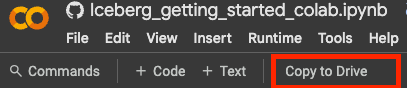

The workshop is consisted of several code cells that are designed to be executed from top to bottom.

For example, this is the a code cell contains code to print "Hello Iceberg Summit"

In [1]:
print("Hello Iceberg Summit")

Hello Iceberg Summit


To execute a cell, click it and press Shift + Enter. The output will be displayed below the cell. Or click the "Run cell" button at the beginning of each cell

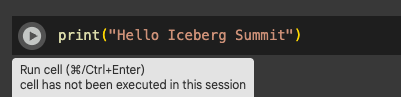


# Iceberg Metadata Structure

![My Image](https://github.com/HonahX/iceberg-summit-workshop/blob/main/notebooks/imgs/iceberg-metadata.png?raw=true)

### Catalog
Catalog is responsible for managing and tracking iceberg tables, pointing to the current metadata file that represent a table's state.

### Metadata files

Table state is maintained in metadata files. All changes to table state create a new metadata file and replace the old metadata with an atomic swap. The table metadata file tracks the table schema, partitioning config, custom properties, and snapshots of the table contents. A snapshot represents the state of a table at some time and is used to access the complete set of data files in the table.

### Data files
Data files in snapshots are tracked by one or more manifest files that contain a row for each data file in the table, the file's partition data, and its metrics. The data in a snapshot is the union of all files in its manifests. Manifest files are reused across snapshots to avoid rewriting metadata that is slow-changing. Manifests can track data files with any subset of a table and are not associated with partitions.

### Manifests and Manifest List
The manifests that make up a snapshot are stored in a manifest list file. Each manifest list stores metadata about manifests, including partition stats and data file counts. These stats are used to avoid reading manifests that are not required for an operation.


Ref: [Iceberg Table Spec Overview](https://iceberg.apache.org/spec/#overview)

# Workshop Outline

In the workshop, we are going to explore basic Iceberg table operations to introduce you to the essentials of Iceberg.

We will use [PyIceberg](https://py.iceberg.apache.org/), a python implementation for accessing iceberg tables.

# Setup

## Install Dependencies

In [ ]:
%pip install pyiceberg[pyarrow,pandas,sql-sqlite]==0.9.0

## A util to print directory

In [ ]:
import os

def print_directory(root_path, indent=''):
    try:
        entries = sorted(os.listdir(root_path))
    except FileNotFoundError:
        print(f"{indent}[Error] Path not found: {root_path}")
        return
    except PermissionError:
        print(f"{indent}[Error] Permission denied: {root_path}")
        return

    for i, entry in enumerate(entries):
        path = os.path.join(root_path, entry)
        is_last = (i == len(entries) - 1)
        branch = '└── ' if is_last else '├── '
        print(f"{indent}{branch}{entry}")
        if os.path.isdir(path):
            new_indent = indent + ('    ' if is_last else '│   ')
            print_directory(path, new_indent)

## Download Example Data

In [ ]:
import os
data_dir = "/data"
os.makedirs(data_dir, exist_ok=True)

!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet -O /data/yellow_tripdata_2024-01.parquet
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet -O /data/yellow_tripdata_2024-02.parquet
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-03.parquet -O /data/yellow_tripdata_2024-03.parquet

## Setup Catalog

First, let's set up a catalog, which allows us to organize, manage, and track tables. Within a catalog, tables are grouped into logical containers called namespaces. You can visualize the structure of a catalog as follows:

```
catalog
├── namespace_1
│   ├── table_1
│   └── table_2
└── namespace_2
    └── table_3
```

In this workshop, we'll start by creating a namespace called `demo_ns`, where we'll store all tables that we create.

In [ ]:
from pyiceberg.catalog import load_catalog


warehouse = "/warehouse"
os.makedirs(warehouse, exist_ok=True)
sqlite_uri = f"sqlite:///:memory:"

catalog = load_catalog("in-memory", warehouse=warehouse, **{
    "uri": sqlite_uri
})

catalog.create_namespace_if_not_exists("demo_ns")

# Cleanup for Re-runnability

To ensure the workshop can be run multiple times without issues, we'll perform a cleanup step here.

In [ ]:
import shutil

try:
    # In case the table already exists
    catalog.drop_table("demo_ns.nyc_taxis")
except:
    pass

shutil.rmtree("/warehouse")

## Example Data: NYC Taxi Dataset

In this workshop, we will use New York City Taxi & Limousine Commission's Trip Record Data, which can be downloaded from https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [ ]:
import pyarrow.parquet as pq

taxis_data_1 = pq.read_table('/data/yellow_tripdata_2024-01.parquet')
taxis_data_2 = pq.read_table('/data/yellow_tripdata_2024-02.parquet')
taxis_data_3 = pq.read_table('/data/yellow_tripdata_2024-03.parquet')
dataset_schema = taxis_data_1.schema
dataset_schema

## Create an Iceberg table

First, we'll create an iceberg table using the dataset's schema. Let's name the table `nyc_taxis`

In [ ]:
TABLE_NAME = "demo_ns.nyc_taxis"

In [ ]:
nyc_taxis_tbl = catalog.create_table(TABLE_NAME, schema=dataset_schema)
nyc_taxis_tbl

## What happens behind table creation?

A metadata file has been created and registered as the latest metadata of table `demo_ns.nyc_taxis`. Let's view the table's location.

In [ ]:
print_directory(nyc_taxis_tbl.location())

# Add data to the table

The table we created is initially empty. Next, we'll add some data to the table to demonstrate how data insertion works and observe the resulting changes.

We will `append` the `taxis_data_1` to the table

In [ ]:
nyc_taxis_tbl.append(taxis_data_1)
nyc_taxis_tbl

## A new snapshot has been added

From the output above, we can see a new snapshot has been created after the data insertion

```
snapshot: Operation.APPEND: id=<id>, schema_id=0
```

This snapshot indicates that the data change operation performed was an Append, matching the insert operation we executed.

## Read the table

To view the contents of the table, we'll read the data into a pandas DataFrame. For demonstration purposes, we'll limit our display to the first 10 rows.

In [ ]:
nyc_taxis_tbl.scan(limit=10).to_pandas()

We can also apply filters and select specific columns from the final result. For example, we might want to view records that have 2 or more passengers and display only certain columns.

In [ ]:
nyc_taxis_tbl.scan(row_filter="passenger_count >= 2", selected_fields=["VendorID", "passenger_count", "fare_amount"], limit=10).to_pandas()

## What happens when adding data?

The data has been written into a parquet file and a new snapshot has been created.

Let's check the table location again:

In [ ]:
print_directory(nyc_taxis_tbl.location())

In the `metadata`, we can see some new files are generated:


*   new metadata file: `00001-<uuid>-.metadata.json`
*   manifest file: `<uuid>-m0.avro`
*   manifest list file: `snap-<snapshot-id>-0-<uuid>.avro`

In the `data`, we can see a new parquet file that contains the inerted data



*   `00000-0-<uuid>.parquet`



# Table Evolution: Make table partitioned

The table we just created is unpartitioned. In this example, we want to take a further step to partition the table. We will partition the table by the `day` value of`tpep_pickup_datatime` column.

We will use `update_spec` API to make the change, see [Partition Evolution](https://py.iceberg.apache.org/api/#partition-evolution) for more details.

In [ ]:
from pyiceberg.transforms import DayTransform

with nyc_taxis_tbl.update_spec() as update_spec:
    update_spec.add_field("tpep_pickup_datetime", DayTransform())

nyc_taxis_tbl

From the output above:
```
partition by: [tpep_pickup_datetime_day]
```
We can see that the table is now partitioned by `tpep_pickup_datetime`. The postfix `_day` indicates that the partitioning is based on the day portion of the datetime value.

Let's add some new data to the table to see how data will be written into different partitions

In [ ]:
nyc_taxis_tbl.append(taxis_data_2)

In [ ]:
nyc_taxis_tbl.scan(limit=3).to_pandas()

# Partitioned Data

If we go to the `data` folder of the table, we can see the newly inserted data partitioned by date.

In [ ]:
print_directory(os.path.join(nyc_taxis_tbl.location(), "data"))

The folder name follows the format `<partition field>=<partition value>`

For example, `tpep_pickup_datetime_day=2024-02-16`indicates that all data files within this folder contain records with a pickup date of `2024-02-16`

# Table Evolution: Updating Partitioning to Month

Suppose we now want future data insertions to be partitioned by the `month` portion of the `tpep_pickup_datetime` column. Thankfully, Iceberg allows us to easily update the partitioning strategy without needing to recreate the table or rewrite existing data.

Let's see how we can do this!

In [ ]:
from pyiceberg.transforms import MonthTransform

with nyc_taxis_tbl.update_spec() as update_spec:
    update_spec.remove_field("tpep_pickup_datetime_day")
    update_spec.add_field("tpep_pickup_datetime", MonthTransform())

nyc_taxis_tbl

From the output above:
```
partition by: [tpep_pickup_datetime_month]
```
We can see that the table is now partitioned by `tpep_pickup_datetime`. The postfix `_month` indicates that the partitioning is based on the month portion of the datetime value.

Now let's append some new data to the table

In [ ]:
nyc_taxis_tbl.append(taxis_data_3)

If we go to the the `data` folder of table `nyc_taxis` again, we will find the new data is partitioned by the month value. (You can find folders of new partitions at the bottom)

```
├── tpep_pickup_datetime_month=2002-12
│   └── 00000-2-<uuid>.parquet
├── tpep_pickup_datetime_month=2024-02
│   └── 00000-1-<uuid>.parquet
├── tpep_pickup_datetime_month=2024-03
│   └── 00000-0-<uuid>.parquet
└── tpep_pickup_datetime_month=2024-04
    └── 00000-3-<uuid>.parquet
```

In [ ]:
print_directory(os.path.join(nyc_taxis_tbl.location(), "data"))

The previous day partitions' folders are still there because data inserted before partition spec change will remain in their original partition.

# Table Evolution: Change Table Schema
Iceberg supports schema evolution without rewriting any data. For example, we can rename `VendorId` to `ID`.

We will use the `update_schema` API to achieve this, see [Schema evolution](https://py.iceberg.apache.org/api/#schema-evolution) for more details

In [ ]:
# Before rename
nyc_taxis_tbl.scan(limit=3).to_pandas()

In [ ]:
with nyc_taxis_tbl.update_schema() as update:
    update.rename_column("VendorID", "ID")

In [ ]:
# After rename
nyc_taxis_tbl.scan(limit=3).to_pandas()

# Metadata Table

We can get more details of an iceberg table by looking at its metadata tables.

## Partitions
For example, to learn about existing partitions in the table, we can query the `partitions` metadata table

In [ ]:
nyc_taxis_tbl.inspect.partitions().to_pandas().query("spec_id == 2")

## Files

If we want to see all the data files in the table, we can query the `files` metadata table

In [ ]:
nyc_taxis_tbl.inspect.files().to_pandas().query("spec_id == 2")

## Snapshots

If we want to look at snapshots of the table, we can query the `snapshots` metadata table.

Every time when a data change operation happens, Iceberg will form a new snapshot. In this example, we did 3 append and therefore we will have 3 snapshots

In [ ]:
nyc_taxis_tbl.inspect.snapshots().to_pandas()

# Interoperability with other engines: Spark

Iceberg tables provides engine/platform interoperability. To see how we can use spark to read tables written by PyIceberg, please use the "Docker" version of the workshop: https://github.com/HonahX/iceberg-summit-workshop